In [2]:
import gensim
import numpy as np
import pandas as pd
from IPython import embed

from ggplot import *
import json
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pyLDAvis.gensim
import seaborn as sns
import warnings
import pickle
import model_visualization
from gensim.models import CoherenceModel, HdpModel

%matplotlib inline
pyLDAvis.enable_notebook()

#pd.options.display.max_rows = 10

In [3]:
with open('text_corpus_id2word_fulldata.pkl', 'rb') as handle:
   texts, id2word, corpus, full_data = pickle.load(handle)
#  texts, id2word, corpus, full_data = generate_corpus.generate_corpus()
# embed()

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


ldamallet =  gensim.models.wrappers.LdaMallet.load('lda.model')
# mallet_path = '/Users/ismglv/dev/lda2vec/mallet/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=60, id2word=id2word)
# # coherence_model = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
# coherence = coherence_model.get_coherence()
# print('\nCoherence Score: ', coherence)

dictionary = texts

df_topic_sents_keywords = model_visualization.format_topics_sentences(ldamallet, corpus, dictionary)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['doc_id', 'dom_topic', 'topic_weight', 'topic_words', 'Text']



# to get doc topics df_dominant_topic['Keywords'][doc_num]
# to get doc topics dominant quality df_dominant_topic['Dominant_Topic'][doc_num]

#Find the most representative document for each topic

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['dom_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['dom_topic', 'topic_words']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['dom_topic', 'topic_words', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

#pyLDAvis.gensim.prepare(model, corpus, id2word)

data = pd.merge(full_data, df_dominant_topic, left_index=True, right_index=True)

arrays_of_data = {}
data_values = data.values
for d in data_values:
    if d[7] in arrays_of_data:
        arrays_of_data[d[7]].append(d)
    else:
        arrays_of_data[d[7]] = []
        arrays_of_data[d[7]].append(d)

counter = 0
part = []
parted_data = []
for i in arrays_of_data:
    if counter == 9:
        part.append(arrays_of_data[i])
        parted_data.append(part)
        counter = 0
        part = []
    else:
        part.append(arrays_of_data[i])
        counter += 1

def merged_list(lists):
    merged_list = []

    for l in lists:
        merged_list += l
    return merged_list
parts = []

for i in parted_data:
    parts.append(merged_list(i))
    
    
def group_topics_by_date(data):
    topics = {}
    for topic in data:
        if topic[3] in topics:
            topics[topic[3]].append(topic)
        else:
            topics[topic[3]] = []
            topics[topic[3]].append(topic)
    return topics

def group_topics_by_topic(data):
    topics = {}
    for topic in data:
        if topic[7] in topics:
            topics[topic[7]].append(topic)
        else:
            topics[topic[7]] = []
            topics[topic[7]].append(topic)
    return topics

def get_avg_of_topic(topics):
    sum = 0
    for topic in topics:
        sum += topic[6]
    return round(sum / len(topics), 3)

def get_key(dict):
    return list(dict.keys())[0]

def get_value(dict):
    return list(dict.values())[0]

def get_graph_data(data):
    result = {"2017-02": [], "2017-03": [], "2017-04": [], "2017-05": [], "2017-06": [], "2017-07": [], "2017-08": []}
    topics_by_date = group_topics_by_date(data)
    for topic in topics_by_date:
        topics = topics_by_date[topic]
        for t in topics:
            sorted_by_topic = group_topics_by_topic(topics)
            result[topic].append({t[7]: get_avg_of_topic(sorted_by_topic[t[7]])})       
    return result   
a = get_graph_data(parts[0])

def get_all_topics(data):
    all_topics = []
    for i in data:
        all_topics.append(i[7])
    return np.unique(all_topics)

def get_avg_weitght_for(topic, data):
    for t in data:
        if get_key(t) == topic:
            return get_value(t)
    return 0

def get_all_avg_weights_for(topic, data):
    avg_weights = []
    for date in data:
        avg_weights.append(get_avg_weitght_for(topic, data[date]))
    return avg_weights


model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]]


In [7]:
#prepare data
dates = ["2017-02", "2017-03", "2017-04", "2017-05", "2017-06", "2017-07", "2017-08"]
prepared_data = get_graph_data(parts[0])
graph_data = {"dates": dates}

all_topics = get_all_topics(parts[0])
for topic in all_topics:
    graph_data[topic] = get_all_avg_weights_for(topic, prepared_data)

df=pd.DataFrame(graph_data)
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('dates', axis=1):
    num+=1
    plt.plot(df['dates'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

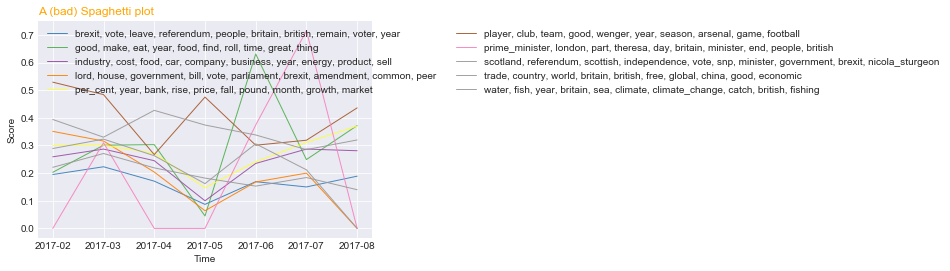

,"brexit, vote, leave, referendum, people, britain, british, remain, voter, year",dates,"good, make, eat, year, food, find, roll, time, great, thing","industry, cost, food, car, company, business, year, energy, product, sell","lord, house, government, bill, vote, parliament, brexit, amendment, common, peer","per_cent, year, bank, rise, price, fall, pound, month, growth, market","player, club, team, good, wenger, year, season, arsenal, game, football","prime_minister, london, part, theresa, day, britain, minister, end, people, british","scotland, referendum, scottish, independence, vote, snp, minister, government, brexit, nicola_sturgeon","trade, country, world, britain, british, free, global, china, good, economic","water, fish, year, britain, sea, climate, climate_change, catch, british, fishing"
0,0.195,2017-02,0.203,0.259,0.351,0.300,0.529,0.000,0.289,0.221,0.394
1,0.223,2017-03,0.301,0.287,0.316,0.301,0.484,0.310,0.323,0.271,0.330
2,0.171,2017-04,0.303,0.245,0.204,0.272,0.267,0.000,0.263,0.219,0.427
3,0.087,2017-05,0.045,0.100,0.064,0.147,0.475,0.000,0.162,0.182,0.374
4,0.169,2017-06,0.631,0.235,0.168,0.241,0.301,0.374,0.306,0.153,0.338
5,0.150,2017-07,0.249,0.287,0.200,0.311,0.319,0.715,0.212,0.184,0.285
6,0.189,2017-08,0.372,0.281,0.000,0.370,0.436,0.000,0.000,0.140,0.320
